In [349]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from torch import optim
from torch import nn
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [350]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)

<Figure size 432x288 with 0 Axes>

# end-to-end training

In [351]:
# I/O
import gzip
import pickle

with gzip.open('my_data/mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin-1')

In [352]:
# read numpy arrays and convert to tensor
X_train, y_train = train_set
X_val, y_val = valid_set
X_test, y_test = test_set

X_train, y_train, X_val, y_val, X_test, y_test = map(torch.from_numpy, [X_train, y_train, X_val, y_val, X_test, y_test])

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([50000, 784])
torch.Size([10000, 784])
torch.Size([10000, 784])


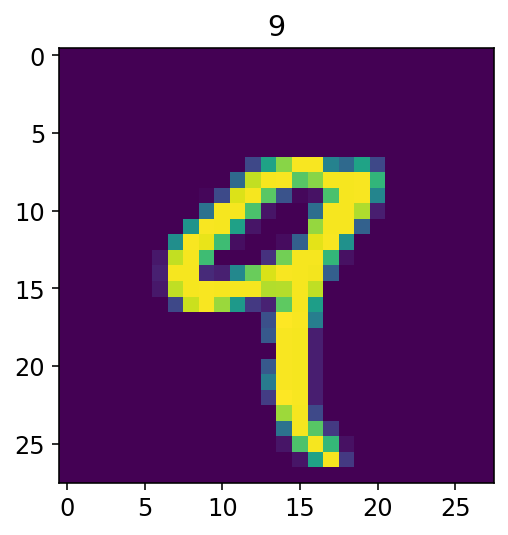

In [322]:
# visualization
plt.imshow(X_train[4].reshape(28,28))
plt.title(y_train[4].item())
plt.show()

In [354]:
# Dataset and DataLoader 
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 50
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [355]:
# understand dimensions
for X, y in train_dataloader: # every X, y means a batch!
    print(X.shape,y.shape)
    break

torch.Size([50, 784]) torch.Size([50])


In [377]:
# NN model

class mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin_1 = nn.Linear(784, 50)
        self.lin_2 = nn.Linear(50, 20)
        self.lin_3 = nn.Linear(20, 10)
        
    def forward(self, xb):
        xb = F.relu(self.lin_1(xb))
        xb = F.relu(self.lin_2(xb))
        xb = F.relu(self.lin_3(xb))
        return xb

# CNN model
class mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1) # in_channel, out_channel
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
#         self.fc_1 = nn.Linear(1000, 50)
#         self.fc_2 = nn.Linear(50, 10)
#         self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28) # the first dimension (batch size) is inferred. dim: [N, C, H, W]
        xb = F.relu(self.conv1(xb))
#         print(xb.shape)
        xb = F.relu(self.conv2(xb))
#         print(xb.shape)
        xb = F.relu(self.conv3(xb))
#         print(xb.shape)
        xb = F.avg_pool2d(xb, 4)
#         print(xb.shape)
#         print(xb.view(-1, xb.size(1)).shape)
        return xb.view(-1, xb.size(1))

In [378]:
model_cnn(X_train[0])

torch.Size([1, 16, 14, 14])
torch.Size([1, 16, 7, 7])
torch.Size([1, 10, 4, 4])
torch.Size([1, 10, 1, 1])
torch.Size([1, 10])


tensor([[ 5.2341,  3.3484, 12.4720, 21.3580,  0.9322, 20.3445,  1.6796,  3.9386,
          8.5845,  7.5027]], grad_fn=<ViewBackward>)

In [367]:
# loss function. Softmax is computed inside cross_entrpy.
loss_function = F.cross_entropy

In [379]:
# initialize model
model_nn = mnist_NN()
model_cnn = mnist_CNN()

In [369]:
# optimizer for updating weights
optimizer_nn = optim.SGD(params=model_nn.parameters(), lr=0.2, momentum=0.9)
optimizer_cnn = optim.SGD(params=model_cnn.parameters(), lr=0.1, momentum=0.9)

In [382]:
# training!
def training(my_model, my_optimizer):
    epochs = 20
    train_loss = []
    val_loss = []
    it = []
    for epoch in tqdm(range(epochs)):
        it.append(epoch)
        my_model.train() # set mode, not actually training
        for i, mini_batch in enumerate(train_dataloader):
            xb, yb = mini_batch
            pred = my_model(xb)
            loss = loss_function(pred, yb)
            
            my_optimizer.zero_grad()
            loss.backward()
            my_optimizer.step()

        my_model.eval()
        with torch.no_grad():
            tmp_train_loss = sum(loss_function(my_model(xb), yb) for xb, yb in train_dataloader).item()/len(train_dataset)
            tmp_val_loss = sum(loss_function(my_model(xb), yb) for xb, yb in val_dataloader).item()/len(val_dataset)
#             print('epoch ' + str(epoch))
#             print('train err: ' + str(np.round(tmp_train_loss,4)) + ', val err: ' + str(np.round(tmp_val_loss,4)))
            train_loss.append(tmp_train_loss)
            val_loss.append(tmp_val_loss)

    return my_model, train_loss, val_loss, it

In [383]:
trained_model_nn, lt, lv, it = training(model_nn, optimizer_nn)

100%|██████████| 20/20 [00:33<00:00,  1.64s/it]


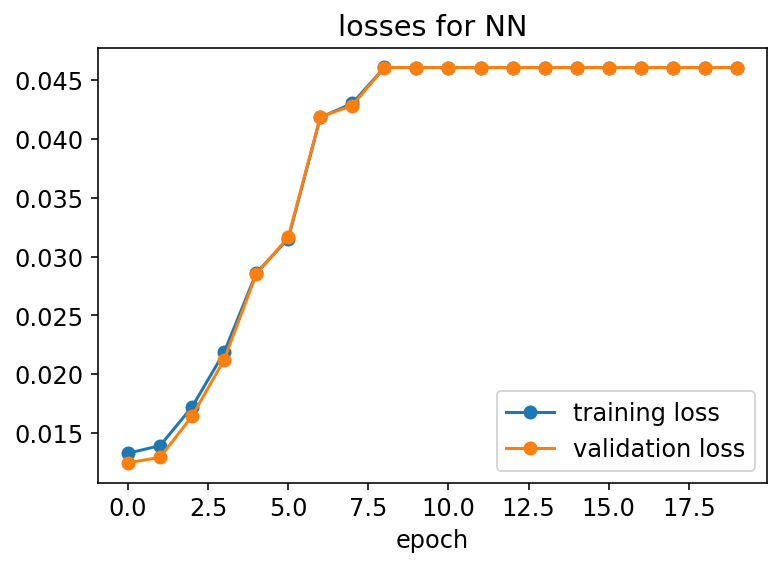

In [372]:
plt.plot(it, lt, 'o-', label='training loss')
plt.plot(it, lv, 'o-', label='validation loss')
plt.legend()
plt.title('losses for NN')
plt.xlabel('epoch')
plt.show()

In [373]:
# output accuracy, NN
y_train_pred = trained_model_nn(X_train)
y_val_pred = trained_model_nn(X_val)
y_test_pred = trained_model_nn(X_test)

print('train accuracy (CNN): ' + str((y_train_pred.argmax(dim=1) == y_train).float().mean().item()))
print('val accuracy (CNN): ' + str((y_val_pred.argmax(dim=1) == y_val).float().mean().item()))
print('test accuracy (CNN): ' + str((y_test_pred.argmax(dim=1) == y_test).float().mean().item()))

train accuracy (CNN): 0.09978000074625015
val accuracy (CNN): 0.09610000252723694
test accuracy (CNN): 0.10090000182390213


In [380]:
trained_model_cnn, lt, lv, it = training(model_cnn, optimizer_cnn)

100%|██████████| 20/20 [02:02<00:00,  6.17s/it]


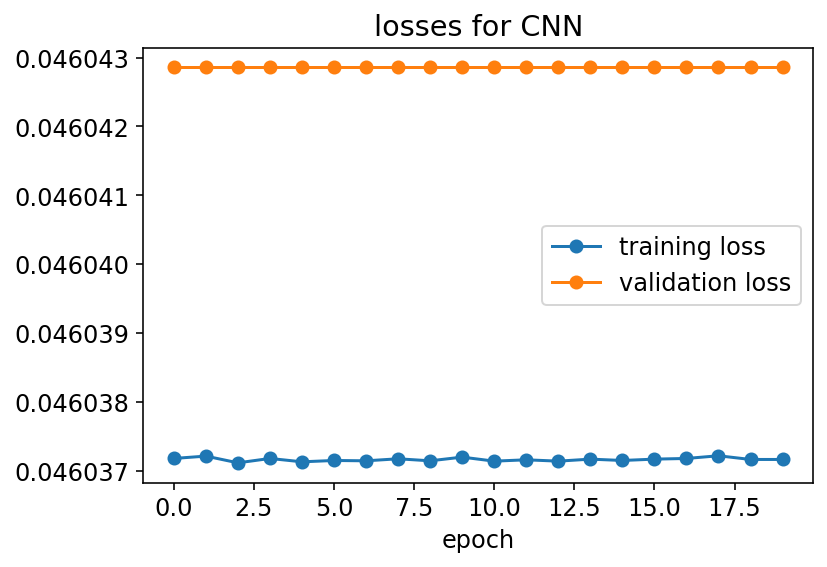

In [381]:
plt.plot(it, lt, 'o-', label='training loss')
plt.plot(it, lv, 'o-', label='validation loss')
plt.legend()
plt.title('losses for CNN')
plt.xlabel('epoch')
plt.show()

In [376]:
# output accuracy, CNN
y_train_pred = trained_model_cnn(X_train)
y_val_pred = trained_model_cnn(X_val)
y_test_pred = trained_model_cnn(X_test)

print('train accuracy (CNN): ' + str((y_train_pred.argmax(dim=1) == y_train).float().mean().item()))
print('val accuracy (CNN): ' + str((y_val_pred.argmax(dim=1) == y_val).float().mean().item()))
print('test accuracy (CNN): ' + str((y_test_pred.argmax(dim=1) == y_test).float().mean().item()))

torch.Size([50000, 16, 14, 14])
torch.Size([50000, 16, 7, 7])
torch.Size([50000, 10, 4, 4])
torch.Size([50000, 10, 1, 1])
torch.Size([50000, 10])
torch.Size([10000, 16, 14, 14])
torch.Size([10000, 16, 7, 7])
torch.Size([10000, 10, 4, 4])
torch.Size([10000, 10, 1, 1])
torch.Size([10000, 10])
torch.Size([10000, 16, 14, 14])
torch.Size([10000, 16, 7, 7])
torch.Size([10000, 10, 4, 4])
torch.Size([10000, 10, 1, 1])
torch.Size([10000, 10])
train accuracy (CNN): 0.9676600098609924
val accuracy (CNN): 0.9664000272750854
test accuracy (CNN): 0.9628999829292297
